<a href="https://colab.research.google.com/github/Abhishek1005/DA/blob/master/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.models import Sequential
import pandas as pd
from tqdm import tqdm_notebook as tqdm_notebook
import numpy as np
df_ge = pd.read_csv("BMW.DE.csv")
df_ge.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5639,2019-08-14,61.099998,61.099998,59.299999,59.599998,59.599998,1972805.0
5640,2019-08-15,59.759998,59.799999,58.040001,58.820000,58.820000,1934815.0
5641,2019-08-16,59.020000,59.639999,58.860001,59.560001,59.560001,1625628.0
5642,2019-08-19,60.230000,60.779999,59.889999,60.360001,60.360001,1283004.0
5643,2019-08-20,60.349998,60.580002,59.560001,59.740002,59.740002,1009171.0


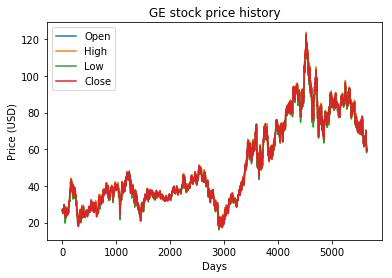

In [3]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

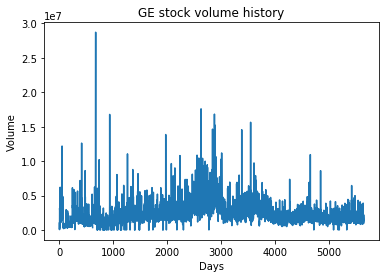

In [4]:
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [5]:
print("checking if any null values are present\n", df_ge.isna().sum())

checking if any null values are present
 Date          0
Open         25
High         25
Low          25
Close        25
Adj Close    25
Volume       25
dtype: int64


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 4515 1129


In [0]:

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - 3
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, 3, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:3+i]
        y[i] = mat[3+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [9]:

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, 1)
y_t = trim_dataset(y_t, 1)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, 1),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, 1),2)


length of time-series i/o (4512, 3, 5) (4512,)



length of time-series i/o (1126, 3, 5) (1126,)


In [11]:
from keras import optimizers
from keras.layers import Dense,Dropout
from keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(2, 3, x_t.shape[2]), stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.9)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)